<a href="https://colab.research.google.com/github/masadeghi/dementia_clf_fmri/blob/main/experiments/analysis_scripts/fmri_dementia_ts_tranformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import dependencies

In [ ]:
import os
import gc
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score
from sklearn.utils import class_weight

!pip install -qU tsai
from tsai.all import *
from fastai.callback.tracker import EarlyStoppingCallback, TrackerCallback
from fastai.vision.all import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.9/298.9 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 63.2 MB/s eta 0:00:00


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set working directory

In [ ]:
# Mount Google drive
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/Coding projects/resting_fmri_dementia/

/content/gdrive/MyDrive/Coding projects/resting_fmri_dementia


# Import data and divide into train/val/test sets
* time series data
* features data

In [ ]:
# Scaled_data
X = np.load('scaled_datasets_as_np_arrays/X_final.npy', mmap_mode = 'c')
y = np.load('scaled_datasets_as_np_arrays/y_final.npy', mmap_mode = 'c')

In [ ]:
train_val_idx = np.load('datasets_as_np_arrays/train_val_idx.npy')
train_idx = np.load('datasets_as_np_arrays/train_idx.npy')
val_idx = np.load('datasets_as_np_arrays/val_idx.npy')
test_idx = np.load('datasets_as_np_arrays/test_idx.npy')

In [ ]:
features_df = pd.read_csv('features_data/features_final_df_custom_mod.csv', index_col = False)
features_df['target'] = features_df['target'].astype('str')

# Model

In [ ]:
splits = tuple([L(list(train_idx)), L(list(val_idx))])

In [ ]:
tfms  = [None, [TSCategorize()]]
batch_tfms = TSStandardize(by_sample=True, by_var=True)
batch_size = 64

dls_ts = get_ts_dls(X, y, splits = splits, tfms = tfms, batch_tfms = batch_tfms, bs = batch_size)

gc.collect()

dls_ts.one_batch()

(TSTensor(samples:64, vars:200, len:140, device=cuda:0, dtype=torch.float32),
 TensorCategory([2, 0, 2, 1, 3, 3, 2, 2, 2, 1, 3, 3, 1, 2, 3, 2, 1, 1, 3, 2, 2,
                 1, 2, 2, 2, 2, 2, 1, 3, 2, 3, 1, 0, 2, 1, 2, 2, 0, 3, 3, 2, 2,
                 3, 3, 1, 2, 2, 1, 1, 2, 1, 0, 2, 2, 1, 3, 3, 2, 2, 1, 2, 1, 2,
                 1], device='cuda:0'))

In [ ]:
cat_names = None
cont_names = features_df.columns[:-1]
y_names = 'target'

dls_features = get_tabular_dls(features_df, # Has normalization of continuous features built in
                                cat_names = cat_names, cont_names = cont_names,
                                y_names = y_names, splits = splits, bs = batch_size)

gc.collect()

dls_features.one_batch()

(tensor([], device='cuda:0', size=(64, 0), dtype=torch.int64),
 tensor([[-0.4992,  1.0317, -0.2573,  ..., -0.3114, -0.0887, -0.5760],
         [-1.7354, -1.5255, -1.5321,  ..., -0.3114, -0.6197, -0.6829],
         [ 0.5574, -0.8563, -0.9183,  ..., -0.3091,  0.3425,  1.3261],
         ...,
         [-0.3164, -0.1872,  0.1912,  ..., -0.0892, -0.4635,  0.3632],
         [-0.0385,  0.8644,  0.4509,  ..., -0.3074, -0.2959, -0.1939],
         [ 0.1028,  0.4581, -1.1308,  ..., -0.1935, -0.2976,  1.4264]],
        device='cuda:0'),
 tensor([[0],
         [1],
         [3],
         [1],
         [3],
         [2],
         [2],
         [0],
         [0],
         [3],
         [3],
         [3],
         [3],
         [0],
         [2],
         [0],
         [0],
         [2],
         [3],
         [3],
         [3],
         [1],
         [1],
         [1],
         [2],
         [1],
         [3],
         [1],
         [0],
         [2],
         [3],
         [2],
         [3],
        

In [ ]:
dls_mixed = get_mixed_dls(dls_ts, dls_features)

dls_mixed.one_batch()

((TSTensor(samples:64, vars:200, len:140, device=cuda:0, dtype=torch.float32),
  (tensor([], device='cuda:0', size=(64, 0), dtype=torch.int64),
   tensor([[-1.1089, -0.1633, -0.2573,  ..., -0.3097, -0.5793, -0.6749],
           [ 0.1414, -0.5456, -0.3517,  ...,  1.1870,  0.1390,  0.0564],
           [-1.0373,  0.5298,  0.2620,  ..., -0.1005, -0.5704, -0.3350],
           ...,
           [ 0.4974, -0.2828, -0.8475,  ..., -0.3086,  1.1114,  0.1633],
           [ 0.1637,  0.1474,  0.2620,  ...,  0.3636, -0.4981, -0.6812],
           [-1.7354, -1.5255, -1.5321,  ..., -0.3114, -0.6197, -0.6829]],
          device='cuda:0'))),
 TensorCategory([3, 2, 2, 2, 2, 1, 3, 2, 1, 1, 0, 1, 2, 1, 1, 0, 3, 3, 1, 3, 2,
                 2, 2, 2, 2, 2, 1, 2, 3, 1, 3, 2, 1, 3, 3, 2, 0, 2, 1, 2, 1, 3,
                 2, 0, 3, 3, 1, 1, 1, 1, 2, 3, 1, 3, 1, 0, 3, 1, 1, 2, 1, 3, 2,
                 1], device='cuda:0'))

In [ ]:
# Settings
c_in = dls_ts.vars  # aka channels, features, variables, dimensions
c_out = dls_ts.c
seq_len = dls_ts.len
max_seq_len = None
d_model = 1024
n_heads = 16
d_k = d_v = None # if None --> d_model // n_heads
d_ff = 256
dropout = 0.1
fc_dropout = 0.3
activation = "gelu"
n_layers = 3
kwargs = {}

model_tst = TSTPlus(c_in, c_out, seq_len, max_seq_len = max_seq_len, d_model = d_model,
            n_heads = n_heads, d_k = d_k, d_v = d_v, d_ff = d_ff, dropout = dropout,
            n_layers = n_layers, fc_dropout = fc_dropout)

In [ ]:
tab_model = build_tabular_model(TabModel, dls = dls_features, layers = [200, 100],
                                    arch_config = {'fc_dropout': 0.2, 'use_bn': True,
                                                    'bn_final': False, 'bn_cont': True,
                                                    'skip': True})

In [ ]:
multimodal_model = MultiInputNet(model_tst, tab_model,
                                    #  multi_output = True
                                     )

In [ ]:
def balanced_accuracy(input, target):
  input, target = input.cpu(), target.cpu()
  input, target = flatten_check(input.argmax(axis = -1), target)
  output = balanced_accuracy_score(target, input)
  return output

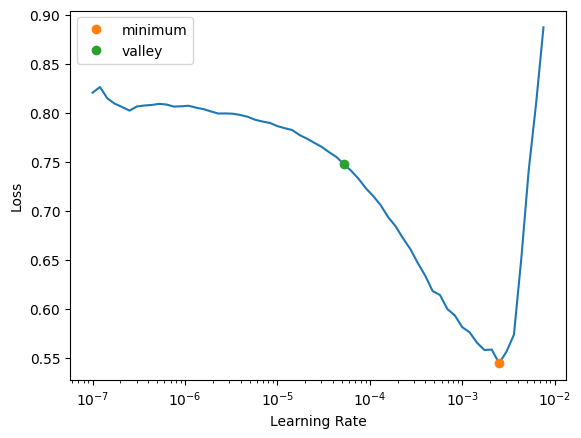

In [ ]:
learn = ts_learner(dls_mixed, multimodal_model, metrics = [balanced_accuracy], cbs = ShowGraph(), loss_func = FocalLoss())
lrs = learn.lr_find(suggest_funcs = (minimum, valley))
final_lr = (lrs.minimum + lrs.valley)/2

epoch,train_loss,valid_loss,balanced_accuracy,time
0,0.779155,26.769758,0.263421,00:04
1,0.690753,49.454269,0.309449,00:04
2,0.581839,94.189262,0.300243,00:04
3,0.465129,181.803894,0.287611,00:04


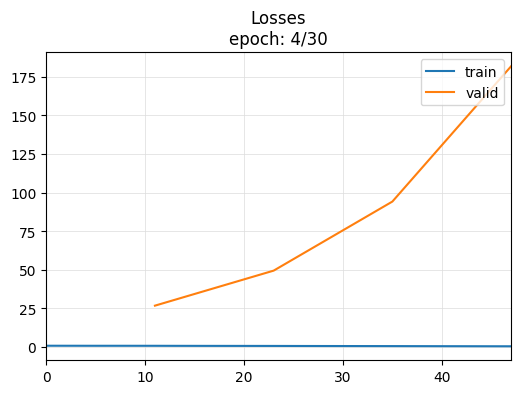

KeyboardInterrupt: ignored

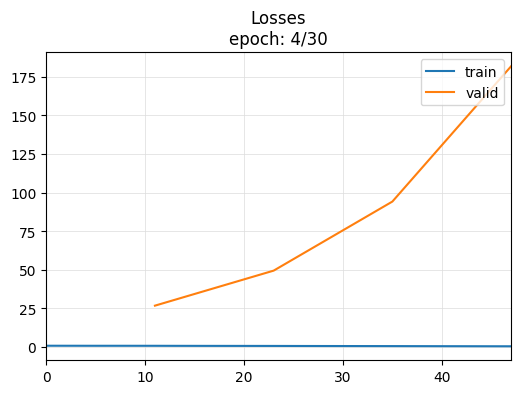

In [ ]:
learn.fit_one_cycle(30, lr_max = final_lr)

In [ ]:
learn = ts_learner(dls_features, tab_model, metrics = [balanced_accuracy], cbs = ShowGraph(), loss_func = FocalLoss())
lrs = learn.lr_find(suggest_funcs = (minimum, valley))
final_lr = (lrs.minimum + lrs.valley)/2

RuntimeError: ignored

In [ ]:
dls_features.one_batch()

(tensor([], device='cuda:0', size=(64, 0), dtype=torch.int64),
 tensor([[ 2.3692,  1.0317,  1.2299,  ..., -0.3079, -0.4094,  1.6119],
         [ 0.9700, -0.5456, -0.4934,  ..., -0.2923,  0.0674, -0.2865],
         [-1.7354, -1.5255, -1.5321,  ..., -0.3114, -0.6197, -0.6829],
         ...,
         [-0.5446, -0.5217, -0.6586,  ..., -0.1074,  0.8038,  0.1186],
         [ 0.5241, -1.4299,  1.1827,  ..., -0.3084,  2.5607,  0.7172],
         [-0.1634,  0.6493, -1.3196,  ..., -0.3111, -0.3872,  0.0472]],
        device='cuda:0'),
 tensor([[1],
         [0],
         [1],
         [3],
         [2],
         [3],
         [2],
         [0],
         [3],
         [3],
         [2],
         [0],
         [1],
         [2],
         [2],
         [0],
         [1],
         [2],
         [2],
         [0],
         [2],
         [2],
         [1],
         [0],
         [1],
         [3],
         [1],
         [2],
         [2],
         [3],
         [1],
         [2],
         [1],
        